In [16]:
import numpy as np
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import Conv2D, Input, Flatten, Dense, Activation, BatchNormalization
from keras.layers import add,AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#preprocessing

import cv2
from sklearn.model_selection import train_test_split
import glob
x_train=[]
y_train=[]
i=0
for item in glob.glob("/content/drive/MyDrive/DATA_AR//*//*"):
    i+=1
    img=cv2.imread(item)
    img=cv2.resize(img,(32,32))
    label=item.split("/")[-2]
    print(label)
    y_train.append(label)
    x_train.append(img)
    #x_train=img
(x_train,y_train)=(x_train,y_train)

x_test=[]
y_test=[]
i=0
for item in glob.glob("/content/drive/MyDrive/DATA_AR//*//*"):
    i+=1
    img=cv2.imread(item)
    img=cv2.resize(img,(32,32))
    label=item.split("/")[-2]
    print(label)
    y_test.append(label)
    x_test.append(img)

(x_test,y_test)=(x_test,y_test)


x_train=np.array(x_train,dtype=np.float32)

x_test=np.array(x_test,dtype=np.float32)

x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255
pixel_mean=np.mean(x_train, axis=0)
x_train=x_train-pixel_mean
x_test=x_test-pixel_mean
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
x_train shape: (25, 32, 32, 3)
y_train shape: (25, 2)
x_test shape: (25, 32, 32, 3)
y_test shape: (25, 2)


In [54]:
#determining hyper parameters
n_classes = 2
n = 3 #number of residuals in stack
n_stacks=3
filters=[16,32,64]
m_train=25
batch_size=8
epochs=80

In [55]:
def resnet_layer(inputs,
                 filters,
                 strides = 1,
                 kernel_size=3,
                 activation='relu',
                 batch_normalization=True
                 ):
    x=Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=strides,
             padding='same',
             kernel_initializer='he_normal',
             kernel_regularizer=l2(1e-4)
             )(inputs)
    if batch_normalization:
       x = BatchNormalization()(x)
    if activation is not None:
       x = Activation('relu')(x)
    return x

In [56]:
inputs = Input(shape=(32,32,3) , name='inputs')
x = inputs
x = resnet_layer(inputs= x, 
                 filters=16)
print('conv_1:', x.shape)
for stack in range(n_stacks):
    for block in range(n):
        if stack != 0 and block == 0:
          strides = 2
        else:
          strides = 1
        y = resnet_layer(inputs=x,
                          filters=filters[stack],
                          strides=strides)
        y=resnet_layer(inputs=y,
                       filters=filters[stack],
                       activation=None)
        if stack != 0 and block == 0:
           x = resnet_layer(inputs=x,
                             filters=filters[stack],
                             kernel_size=1,
                             strides=2,
                             activation=None,
                             batch_normalization=False
                            )
        x= add([x,y])
        x= Activation('relu')(x)
x= AveragePooling2D(8)(x)
x=Flatten()(x)
outputs=Dense(2, activation='softmax', kernel_initializer='he_normal')(x)

conv_1: (None, 32, 32, 16)


In [57]:
model=Model(inputs,outputs,name='alphares')
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])
model.summary()

Model: "alphares"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 32, 32, 16)   448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 32, 32, 16)   64          conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 32, 32, 16)   0           batch_normalization_76[0][0]     
___________________________________________________________________________________________

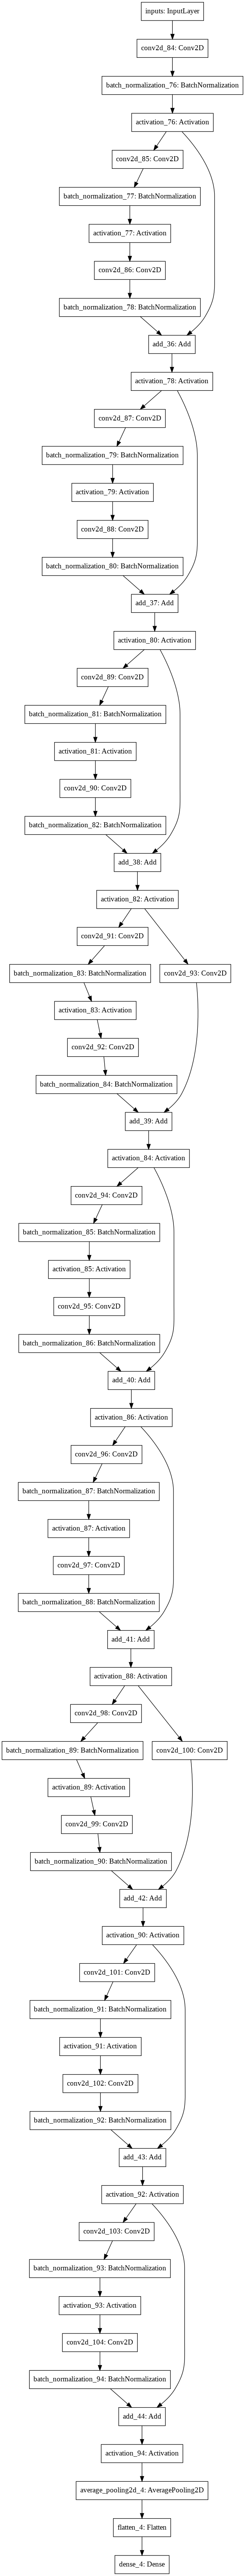

In [58]:
plot_model(model, to_file='model.png')

In [59]:
def lr_scheduler(epoch) :
    lr=1e-3
    if epoch>180:
      lr *=0.5e-3
    elif epoch>160:
      lr *= 1e-3
    elif epoch>120:
      lr *=1e-2
    elif epoch>80:
      lr *=1e-1
    return lr

In [60]:
lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)
check_point=ModelCheckpoint(filepath='alphares.h5',
                            monitor='val_acc',
                            save_best_only=True,
                            verbose=1)
lr_reducer=ReduceLROnPlateau(monitor='val_loss',
                             patience=5,
                             factor=np.sqrt(0.1),
                             cooldown=0,
                             verbose=1,
                             mean_lr=0.5e-6)

In [61]:
data_generator=ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
data_generator.fit(x_train)



model.fit_generator(data_generator.flow(x_train,y_train, batch_size= batch_size),
                    steps_per_epoch=m_train//batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[check_point, lr_scheduler, lr_reducer])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 4s 367ms/step - loss: 0.9996 - acc: 0.4118 - val_loss: 0.8579 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to alphares.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 0s 47ms/step - loss: 0.7329 - acc: 0.7059 - val_loss: 1.0640 - val_acc: 0.4400

Epoch 00002: val_acc did not improve from 0.44000
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 0s 39ms/step - loss: 0.9082 - acc: 0.5833 - val_loss: 1.0425 - val_acc: 0.4400

Epoch 00003: val_acc did not improve from 0.44000
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 0s 36ms/step - loss: 0.7786 - acc: 0.7083 - val_loss: 1.2161 - val_acc: 0.4400

Epoch 00004: val_acc did not improve from 0.44000
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
3/3 [==============================] - 0s 36ms/step - loss: 0.8072 - acc: 0.6471 - val_loss: 1.3170 - val_acc: 0.4400

Epoch 00005: val_acc did not improve from 0.44000
Epoch 6/